In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
import pickle
import glob
from collections import defaultdict, Counter

# plt 세팅
plt.rc('font', family='Malgun Gothic')  # 한글 폰트
plt.rc('axes', unicode_minus=False)  # 마이너스 기호

In [2]:
def load_all_region_data(dataset_dir):
    all_files = glob.glob(os.path.join(dataset_dir, '*.csv'))
    dfs = []
    for file in all_files:
        region_name = os.path.splitext(os.path.basename(file))[0].split('_')[0]  # 서울_202412.csv -> 서울
        df = pd.read_csv(file, encoding='utf-8')
        selected_columns = ['상가업소번호', '상호명', '상권업종소분류명']
        df_region = df[selected_columns].copy()
        df_region['지역'] = region_name
        df_clean = df_region.dropna(subset=['상호명', '상권업종소분류명'])
        dfs.append(df_clean)
        print(f"{region_name} 데이터 크기: {df_clean.shape}")
    region_all_df = pd.concat(dfs, ignore_index=True)
    print(f"전체 통합 데이터 크기: {region_all_df.shape}")

    return region_all_df

In [58]:
region_all_df = load_all_region_data('./dataset')

강원 데이터 크기: (111392, 4)


C:\Users\hojin\AppData\Local\Temp\ipykernel_34264\1633060659.py:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='utf-8')


경기 데이터 크기: (672885, 4)
경남 데이터 크기: (176942, 4)
경북 데이터 크기: (147012, 4)
광주 데이터 크기: (78148, 4)
대구 데이터 크기: (119621, 4)
대전 데이터 크기: (80589, 4)
부산 데이터 크기: (161439, 4)
서울 데이터 크기: (553535, 4)
세종 데이터 크기: (15298, 4)
울산 데이터 크기: (55885, 4)
인천 데이터 크기: (138166, 4)
전남 데이터 크기: (102544, 4)


C:\Users\hojin\AppData\Local\Temp\ipykernel_34264\1633060659.py:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='utf-8')


전북 데이터 크기: (99935, 4)
제주 데이터 크기: (59745, 4)
충남 데이터 크기: (125116, 4)
충북 데이터 크기: (94587, 4)
전체 통합 데이터 크기: (2792839, 4)


In [59]:
print(region_all_df['지역'].value_counts())

지역
경기    672885
서울    553535
경남    176942
부산    161439
경북    147012
인천    138166
충남    125116
대구    119621
강원    111392
전남    102544
전북     99935
충북     94587
대전     80589
광주     78148
제주     59745
울산     55885
세종     15298
Name: count, dtype: int64


In [60]:
# 결측치 확인
print("결측치 개수:")
missing_values = region_all_df.isnull().sum()
print(missing_values)

결측치 개수:
상가업소번호      0
상호명         0
상권업종소분류명    0
지역          0
dtype: int64


In [61]:
region_all_df

,상가업소번호,상호명,상권업종소분류명,지역
0,MA010120220800001545,클러버,요리 주점,강원
1,MA010120220800001666,최병영법률사무소,변호사,강원
2,MA010120220800002200,깡통,남성 의류 소매업,강원
3,MA010120220800002703,금수강산컨설팅,부동산 중개/대리업,강원
4,MA010120220800004187,우리약초,채소/과일 소매업,강원
...,...,...,...,...
2792834,MA0106202201A2188326,고캠프,운동용품 소매업,충북
2792835,MA0106202201A0857023,사진,사진촬영업,충북
2792836,MA0106202201A2048521,올리비아로렌,기타 의류 소매업,충북
2792837,MA0106202201A0896107,박대장김밥,김밥/만두/분식,충북


In [62]:
# class_remap.csv 파일을 읽어옵니다.
remap_file_path = './processed_data/class_remap.CSV'
remap_df = pd.read_csv(remap_file_path)

# 소분류명 매핑 딕셔너리를 생성합니다.
remap_dict = pd.Series(remap_df['소분류_Remap'].values, index=remap_df['소분류명']).to_dict()

# '상권업종소분류명'에 매핑을 적용하여 '상권업종소분류명_remap' 컬럼을 생성합니다.
# 매핑되지 않는 값은 원래 값을 사용합니다.
region_all_df['상권업종소분류명_remap'] = region_all_df['상권업종소분류명'].map(remap_dict).fillna(region_all_df['상권업종소분류명'])

# 변경 결과 및 고유 값 개수 변화 확인
print("매핑 적용 후 상위 10개 행:")
display(region_all_df[['상권업종소분류명', '상권업종소분류명_remap']].head(10))

print(f"\n매핑 전 고유 업종 수: {region_all_df['상권업종소분류명'].nunique()}")
print(f"매핑 후 고유 업종 수: {region_all_df['상권업종소분류명_remap'].nunique()}")

매핑 적용 후 상위 10개 행:


,상권업종소분류명,상권업종소분류명_remap
0,요리 주점,요리 주점
1,변호사,법무 서비스업
2,남성 의류 소매업,의류 소매업
3,부동산 중개/대리업,부동산 중개/대리업
4,채소/과일 소매업,채소/과일 소매업
5,횟집,한식 음식점업
6,노래방,오락 서비스업
7,노래방,오락 서비스업
8,경양식,일식 음식점업
9,펜션,숙박업



매핑 전 고유 업종 수: 247
매핑 후 고유 업종 수: 125


In [63]:
region_all_df

,상가업소번호,상호명,상권업종소분류명,지역,상권업종소분류명_remap
0,MA010120220800001545,클러버,요리 주점,강원,요리 주점
1,MA010120220800001666,최병영법률사무소,변호사,강원,법무 서비스업
2,MA010120220800002200,깡통,남성 의류 소매업,강원,의류 소매업
3,MA010120220800002703,금수강산컨설팅,부동산 중개/대리업,강원,부동산 중개/대리업
4,MA010120220800004187,우리약초,채소/과일 소매업,강원,채소/과일 소매업
...,...,...,...,...,...
2792834,MA0106202201A2188326,고캠프,운동용품 소매업,충북,운동용품 소매업
2792835,MA0106202201A0857023,사진,사진촬영업,충북,사진촬영업
2792836,MA0106202201A2048521,올리비아로렌,기타 의류 소매업,충북,의류 소매업
2792837,MA0106202201A0896107,박대장김밥,김밥/만두/분식,충북,김밥/만두/분식


In [64]:
# 상호명 정규화
def normalize_store_name(name):
    cleaned = re.sub(r'[^가-힣a-zA-Z0-9]', ' ', name) # 한글, 영문, 숫자만 남기고 나머지는 공백으로 변환
    # 변환 후 연속된 공백 제거
    cleaned = re.sub('  ', ' ', cleaned).strip()
    cleaned = re.sub('   ', ' ', cleaned).strip()
    cleaned = re.sub('    ', ' ', cleaned).strip()
    # 소문자? 대문자? 원본 그대로?
    # return cleaned
    return cleaned.lower() 
    # return cleaned.upper()

In [65]:
region_all_df['상호명_Regulated'] = region_all_df['상호명'].apply(normalize_store_name)
region_all_df

,상가업소번호,상호명,상권업종소분류명,지역,상권업종소분류명_remap,상호명_Regulated
0,MA010120220800001545,클러버,요리 주점,강원,요리 주점,클러버
1,MA010120220800001666,최병영법률사무소,변호사,강원,법무 서비스업,최병영법률사무소
2,MA010120220800002200,깡통,남성 의류 소매업,강원,의류 소매업,깡통
3,MA010120220800002703,금수강산컨설팅,부동산 중개/대리업,강원,부동산 중개/대리업,금수강산컨설팅
4,MA010120220800004187,우리약초,채소/과일 소매업,강원,채소/과일 소매업,우리약초
...,...,...,...,...,...,...
2792834,MA0106202201A2188326,고캠프,운동용품 소매업,충북,운동용품 소매업,고캠프
2792835,MA0106202201A0857023,사진,사진촬영업,충북,사진촬영업,사진
2792836,MA0106202201A2048521,올리비아로렌,기타 의류 소매업,충북,의류 소매업,올리비아로렌
2792837,MA0106202201A0896107,박대장김밥,김밥/만두/분식,충북,김밥/만두/분식,박대장김밥


In [66]:
# 중복 상호명 확인
df_len = len(region_all_df.index)
unique_name_counts = region_all_df['상호명_Regulated'].value_counts()
duplicated_names = unique_name_counts[unique_name_counts > 1]

print(f"중복된 상호명 수: {len(duplicated_names)} / {df_len}")
print("고유 상호명 수 :", len(unique_name_counts))
print(f"전체 상호명 중 중복 비율: {(df_len - len(unique_name_counts)) / df_len * 100:.2f}%")

print("\n가장 많이 중복된 상호명")
print(duplicated_names.head(20))

중복된 상호명 수: 265097 / 2792839
고유 상호명 수 : 1818083
전체 상호명 중 중복 비율: 34.90%

가장 많이 중복된 상호명
상호명_Regulated
스타벅스          1907
컴퓨터수리         1736
입시 교과학원       1096
입주청소           976
김밥천국           880
업소명없음          778
투다리            680
슈퍼마켓           652
경영 컨설팅업        634
아모레카운셀러        569
아지트            535
교촌치킨           509
맘스터치           489
파리바게뜨          487
다온             477
태후사랑           461
처갓집양념치킨        460
현대공인중개사사무소     459
삼성공인중개사사무소     452
네네치킨           435
Name: count, dtype: int64


In [67]:
# 중복 상호명의 업종 분포 확인
for name in duplicated_names.index[:5]:
    categories = region_all_df[region_all_df['상호명_Regulated'] == name]['상권업종소분류명_remap'].value_counts()
    print(f"\n'{name}' 업종 분포:")
    print(categories)


'스타벅스' 업종 분포:
상권업종소분류명_remap
카페             1904
경영 컨설팅업           1
주방/가정용품 소매업       1
오락 서비스업           1
Name: count, dtype: int64

'컴퓨터수리' 업종 분포:
상권업종소분류명_remap
컴퓨터/노트북/프린터 수리업    1636
가전제품 수리업             42
컴퓨터/소프트웨어 소매업        27
가정용품 수리업             12
핸드폰/통신장비 수리업         10
핸드폰 소매업               3
전문 서비스업               2
의류/이불 수선업             2
가죽/가방/신발 수선업          1
광고업                   1
Name: count, dtype: int64

'입시 교과학원' 업종 분포:
상권업종소분류명_remap
학원    1096
Name: count, dtype: int64

'입주청소' 업종 분포:
상권업종소분류명_remap
사업시설 관리 서비스업    974
가정용품 수리업          1
광고업               1
Name: count, dtype: int64

'김밥천국' 업종 분포:
상권업종소분류명_remap
김밥/만두/분식    880
Name: count, dtype: int64


In [68]:
def process_duplicate_stores(df, store_col='상호명_Regulated', category_col='상권업종소분류명_remap', verbose=True):
    # 상호명 중복 처리 함수 - 상호명이 중복된 경우 가장 빈도가 높은 업종의 첫번째 컬럼만 남김
    start_time = time.time()
    
    if verbose:
        print(f"원본 데이터: {len(df):,}개 행")
    
    # 고유 상호명을 구해 중복/비중복 여부 구분
    unique_name_counts = df[store_col].value_counts()
    lv_nodup_names = unique_name_counts[unique_name_counts == 1]
    lv_dup_names = unique_name_counts[unique_name_counts > 1]
    
    if verbose:
        print(f"총 고유 상호명 수: {len(unique_name_counts):,}")
        print(f"중복 없는 상호명 수: {len(lv_nodup_names):,}")
        print(f"중복 있는 상호명 수: {len(lv_dup_names):,}")
    
    # 비중복 상호명을 가진 행 리스트에 저장
    selected_rows = df[df[store_col].isin(lv_nodup_names.index)]
    
    if verbose:
        print(f"중복 없는 상호명 처리 완료: {len(selected_rows):,}개 행")
    
    # 중복 상호명 처리
    lv_dup_df = df[df[store_col].isin(lv_dup_names.index)]
    lv_dup_df = lv_dup_df.reset_index(drop=True) #!!인덱스 중복으로 여러 컬럼이 선택되는 문제 해결
    
    if verbose:
        print(f"중복 있는 상호명 데이터: {len(lv_dup_df):,}개 행")
    
    # 업종 빈도 계산
    if verbose:
        print("업종 빈도 계산 시작")
        
    # dict를 활용하여 각 상호명별 업종 빈도 계산
    name_category_counters = defaultdict(Counter)
    for _, row in lv_dup_df.iterrows():
        name = row[store_col]
        category = row[category_col]
        name_category_counters[name][category] += 1
    
    if verbose:
        print(f"업종 빈도 계산 완료: {len(name_category_counters):,}개 상호명")
    
    # 각 상호명별 최빈 업종 저장
    name_top_category = {}  # 각 상호명의 최빈 업종을 저장
    name_first_index = {}   # 각 상호명+최빈업종의 첫 인덱스를 저장
    
    # 각 상호명의 최빈 업종 찾기
    for name, category_counter in name_category_counters.items():
        if len(category_counter) > 0:
            most_common = category_counter.most_common(1)[0]
            top_category = most_common[0]  # 가장 빈도가 높은 업종
            name_top_category[name] = top_category
    
    # 최빈 업종의 첫 번째 인덱스 찾기
    if verbose:
        print("각 상호명별 최빈 업종 탐색")
        
    for idx, row in lv_dup_df.iterrows():
        name = row[store_col]
        category = row[category_col]
        # 상호명에 대한 최빈 업종과 일치하는 경우의 인덱스 저장
        if name in name_top_category and category == name_top_category[name] and name not in name_first_index:
            name_first_index[name] = idx
    
    # 인덱스 value를 모아 리스트로
    selected_indices = list(name_first_index.values())
    
    if verbose:
        print(f"선택된 중복 상호명 인덱스 수: {len(selected_indices):,}")
    
    # 인덱스를 기준으로 데이터프레임 생성
    selected_rows_dup = lv_dup_df.loc[selected_indices]
    
    if verbose:
        print(f"중복 있는 상호명 처리 완료: {len(selected_rows_dup):,}개 행 선택됨")
    
    # 중복/비중복 df concat
    lv_final_df = pd.DataFrame(columns=df.columns)
    lv_final_df = pd.concat([lv_final_df, selected_rows, selected_rows_dup], ignore_index=True)
    
    if verbose:
        print(f"최종 데이터 크기: {len(lv_final_df):,}개 행")
        print(f"제거된 중복 데이터: {len(df) - len(lv_final_df):,}개 행")
        print(f"총 소요 시간: {time.time() - start_time:.2f}초")
    
    return lv_final_df

In [69]:
# 중복 상호명 처리
processed_df = process_duplicate_stores(region_all_df, verbose=True)

원본 데이터: 2,792,839개 행
총 고유 상호명 수: 1,818,083
중복 없는 상호명 수: 1,552,986
중복 있는 상호명 수: 265,097
중복 없는 상호명 처리 완료: 1,552,986개 행
중복 있는 상호명 데이터: 1,239,853개 행
업종 빈도 계산 시작
업종 빈도 계산 완료: 265,097개 상호명
각 상호명별 최빈 업종 탐색
선택된 중복 상호명 인덱스 수: 265,097
중복 있는 상호명 처리 완료: 265,097개 행 선택됨
최종 데이터 크기: 1,818,083개 행
제거된 중복 데이터: 974,756개 행
총 소요 시간: 43.68초


In [70]:
unique_name_counts = processed_df['상호명_Regulated'].value_counts()
lv_nodup_names = unique_name_counts[unique_name_counts == 1]
lv_dup_names = unique_name_counts[unique_name_counts > 1]

In [71]:
len(lv_nodup_names)

1818083

# 여기서부터 다시 작성

In [72]:
# 상호명 중복제거 확인
def check_processing_results(original_df, processed_df, sample_names):
    for name in sample_names:
        print(f"\n'{name}' 처리 결과:")
        # 원본 데이터에서 해당 상호명 검색
        original_records = original_df[original_df['상호명_Regulated'] == name]
        print(f"원본 레코드 수: {len(original_records)}")
        # 처리된 데이터에서 해당 상호명 검색
        processed_records = processed_df[processed_df['상호명_Regulated'] == name]
        print(f"처리 후 레코드 수: {len(processed_records)}")

        print("<원본 업종 분포>")
        print(original_records['상권업종소분류명_remap'].value_counts())
        print("<처리 후 업종 분포>")
        print(processed_records['상권업종소분류명_remap'].value_counts())

        print("\n처리된 레코드:")
        print(processed_records[['상호명', '상호명_Regulated', '상권업종소분류명_remap']])

# 확인할 상호명 샘플링
sample_names = duplicated_names.index[:5].tolist()  # 상위 5개

# 처리 결과 확인
check_processing_results(region_all_df, processed_df, sample_names)



'스타벅스' 처리 결과:
원본 레코드 수: 1907
처리 후 레코드 수: 1
<원본 업종 분포>
상권업종소분류명_remap
카페             1904
경영 컨설팅업           1
주방/가정용품 소매업       1
오락 서비스업           1
Name: count, dtype: int64
<처리 후 업종 분포>
상권업종소분류명_remap
카페    1
Name: count, dtype: int64

처리된 레코드:
          상호명 상호명_Regulated 상권업종소분류명_remap
1581511  스타벅스          스타벅스             카페

'컴퓨터수리' 처리 결과:
원본 레코드 수: 1736
처리 후 레코드 수: 1
<원본 업종 분포>
상권업종소분류명_remap
컴퓨터/노트북/프린터 수리업    1636
가전제품 수리업             42
컴퓨터/소프트웨어 소매업        27
가정용품 수리업             12
핸드폰/통신장비 수리업         10
핸드폰 소매업               3
전문 서비스업               2
의류/이불 수선업             2
가죽/가방/신발 수선업          1
광고업                   1
Name: count, dtype: int64
<처리 후 업종 분포>
상권업종소분류명_remap
컴퓨터/노트북/프린터 수리업    1
Name: count, dtype: int64

처리된 레코드:
           상호명 상호명_Regulated   상권업종소분류명_remap
1574606  컴퓨터수리         컴퓨터수리  컴퓨터/노트북/프린터 수리업

'입시 교과학원' 처리 결과:
원본 레코드 수: 1096
처리 후 레코드 수: 1
<원본 업종 분포>
상권업종소분류명_remap
학원    1096
Name: count, dtype: int64
<처리 후 업종 분포>
상권업종소분류명_remap
학원    1
Name: 

In [73]:
# 좀 더 상세한 정제를 위한 함수 (추가 패턴 처리)
def clean_category_names_advanced(df):
    """
    상권업종소분류명을 가계부에 더 적합한 형태로 변환 (상세 버전):
    1. '*소매업'에서 '소매업' 제거
    2. '*수리업', '*수선업', '*서비스업', '*청소업'에서 '업' 제거
    3. '기타 *', '그 외 *' 등의 패턴 정리
    4. 특수문자 처리
    """
    print("소분류명 상세 정제 시작...")
    start_time = time.time()
    
    # 원본 데이터 복사
    df_clean = df.copy()
    
    # 변환 전 고유 소분류명 수 확인
    original_categories = df_clean['상권업종소분류명_remap'].unique()
    print(f"변환 전 고유 소분류명 수: {len(original_categories)}")
    
    # 패턴 사전 정의
    remove_suffix_patterns = {
        r'소매업$': '',           # '소매업'으로 끝나는 경우 제거
        r'(수리|수선|서비스|청소|대리|중개|매매|판매|컨설팅|대행|음식점|숙박|대여)업$': r'\1',  # '수리업' -> '수리'로 변환
    }

    # 변환 함수
    def transform_category_advanced(category):
        # 소문자 변환 없이 원본 그대로 사용
        transformed = category
        
        # 접미사 패턴 처리
        for pattern, replacement in remove_suffix_patterns.items():
            transformed = re.sub(pattern, replacement, transformed)
        
        return transformed.strip()  # 앞뒤 공백 제거
    
    # 변환 적용
    df_clean['업종소분류_Regulated'] = df_clean['상권업종소분류명_remap'].apply(transform_category_advanced)
    
    # 변환 후 고유 소분류명 수 확인
    cleaned_categories = df_clean['업종소분류_Regulated'].unique()
    print(f"변환 후 고유 소분류명 수: {len(cleaned_categories)}")
    
    # 변환 예시 출력
    print("\n변환 예시 (변경된 항목만):")
    examples = []
    for orig, cleaned in zip(original_categories, 
                            [transform_category_advanced(cat) for cat in original_categories]):
        if orig != cleaned:
            examples.append((orig, cleaned))
    
    # 최대 30개까지만 출력
    for orig, cleaned in examples:
        print(f"  '{orig}' \t\t -> \t\t '{cleaned}'")
    
    # 변경 안 된 예시도 몇 개 출력
    unchanged = [(orig, orig) for orig in original_categories if orig == transform_category_advanced(orig)]
    if unchanged:
        print("\n변경되지 않은 항목 예시 (5개):")
        for orig, cleaned in unchanged:
            print(f"  '{orig}' (변경 없음)")
    
    print(f"\n소분류명 정제 완료. 소요 시간: {time.time() - start_time:.2f}초")
    
    return df_clean

In [74]:
proc_shop_cat_df = clean_category_names_advanced(processed_df)

소분류명 상세 정제 시작...
변환 전 고유 소분류명 수: 125
변환 후 고유 소분류명 수: 125

변환 예시 (변경된 항목만):
  '법무 서비스업' 		 -> 		 '법무 서비스'
  '부동산 중개/대리업' 		 -> 		 '부동산 중개/대리'
  '오락 서비스업' 		 -> 		 '오락 서비스'
  '일식 음식점업' 		 -> 		 '일식 음식점'
  '숙박업' 		 -> 		 '숙박'
  '스포츠 서비스업' 		 -> 		 '스포츠 서비스'
  '반찬/식료품 소매업' 		 -> 		 '반찬/식료품'
  '의류 소매업' 		 -> 		 '의류'
  '의류/이불 수선업' 		 -> 		 '의류/이불 수선'
  '액세서리/잡화 소매업' 		 -> 		 '액세서리/잡화'
  '한식 음식점업' 		 -> 		 '한식 음식점'
  '양식 음식점업' 		 -> 		 '양식 음식점'
  '애완동물/애완용품 소매업' 		 -> 		 '애완동물/애완용품'
  '사업시설 관리 서비스업' 		 -> 		 '사업시설 관리 서비스'
  '중식 음식점업' 		 -> 		 '중식 음식점'
  '화장품 소매업' 		 -> 		 '화장품'
  '가전제품 수리업' 		 -> 		 '가전제품 수리'
  '핸드폰 소매업' 		 -> 		 '핸드폰'
  '채소/과일 소매업' 		 -> 		 '채소/과일'
  '전문 서비스업' 		 -> 		 '전문 서비스'
  '자동차 대여업' 		 -> 		 '자동차 대여'
  '중고 상품 소매업' 		 -> 		 '중고 상품'
  '가구 소매업' 		 -> 		 '가구'
  '건축 서비스업' 		 -> 		 '건축 서비스'
  '건설 자재 소매업' 		 -> 		 '건설 자재'
  '컴퓨터/소프트웨어 소매업' 		 -> 		 '컴퓨터/소프트웨어'
  '디자인 서비스업' 		 -> 		 '디자인 서비스'
  '가정용품 수리업' 		 -> 		 '가정용품 수리'
  '스포츠/레크리에이션 용품 대여업' 		 -> 		 '스포츠/레크리에이션 용품 대여'
  

In [75]:
proc_shop_cat_df

,상가업소번호,상호명,상권업종소분류명,지역,상권업종소분류명_remap,상호명_Regulated,업종소분류_Regulated
0,MA010120220800001666,최병영법률사무소,변호사,강원,법무 서비스업,최병영법률사무소,법무 서비스
1,MA010120220800002703,금수강산컨설팅,부동산 중개/대리업,강원,부동산 중개/대리업,금수강산컨설팅,부동산 중개/대리
2,MA010120220800005673,신나래노래연습장,노래방,강원,오락 서비스업,신나래노래연습장,오락 서비스
3,MA010120220800006098,스포렉스노래연습장,노래방,강원,오락 서비스업,스포렉스노래연습장,오락 서비스
4,MA010120220800006350,유스패밀리&비비큐,경양식,강원,일식 음식점업,유스패밀리 비비큐,일식 음식점
...,...,...,...,...,...,...,...
1818078,MA0106202303A0845779,위너스쇼파,가구 소매업,충북,가구 소매업,위너스쇼파,가구
1818079,MA0106202304A0278079,용인정보,자동차 부품 소매업,충북,자동차 정비,용인정보,자동차 정비
1818080,MA0106202303A0872269,제천숯불갈비,돼지고기 구이/찜,충북,한식 음식점업,제천숯불갈비,한식 음식점
1818081,MA0106202306A1967506,온다베이크,백반/한정식,충북,한식 음식점업,온다베이크,한식 음식점


In [76]:
def encode_categories(df, category_col='상권업종소분류명_remap', class_col='클래스', save_mapping=True, mapping_file='./processed_data/category_mapping_remapped.pkl'):
    """
    업종소분류를 클래스 인코딩하는 함수
    
    Parameters:
    -----------
    df : pandas.DataFrame
        처리할 데이터프레임
    category_col : str
        업종소분류가 저장된 컬럼명
    class_col : str
        생성할 클래스 컬럼명
    save_mapping : bool
        매핑 정보를 파일로 저장할지 여부
    mapping_file : str
        매핑 정보를 저장할 파일명
        
    Returns:
    --------
    pandas.DataFrame
        클래스 인코딩이 추가된 데이터프레임
    dict
        업종소분류-클래스 매핑 딕셔너리
    """
    # 고유 업종 추출 및 정렬 (정렬하면 일관성 유지 가능)
    unique_categories = sorted(df[category_col].unique())
    
    # 각 업종에 C1, C2, ... 형태의 클래스 할당
    category_to_class = {category: f'{i}' for i, category in enumerate(unique_categories)}
    
    # 클래스 컬럼 추가
    df[class_col] = df[category_col].map(category_to_class)
    
    # 결과 확인
    print(f"총 {len(unique_categories):,}개의 고유 업종 클래스로 인코딩 완료")
    print(f"첫 10개 업종-클래스 매핑:")
    for i, (category, class_id) in enumerate(list(category_to_class.items())[:10]):
        print(f"{i+1}. {category} -> {class_id}")
    
    # 매핑 정보 저장
    if save_mapping:
        with open(mapping_file, 'wb') as f:
            pickle.dump(category_to_class, f)
        print(f"매핑 정보를 '{mapping_file}'에 저장했습니다.")
    
    return df, category_to_class

In [77]:
_, encode_df = encode_categories(proc_shop_cat_df, '업종소분류_Regulated')

총 125개의 고유 업종 클래스로 인코딩 완료
첫 10개 업종-클래스 매핑:
1. 가구 -> 0
2. 가발 -> 1
3. 가전제품 -> 2
4. 가전제품 수리 -> 3
5. 가정용품 수리 -> 4
6. 가죽/가방/신발 수선 -> 5
7. 가축 사료 -> 6
8. 건강보조식품 -> 7
9. 건설 자재 -> 8
10. 건어물/젓갈 -> 9
매핑 정보를 './processed_data/category_mapping_remapped.pkl'에 저장했습니다.


In [78]:
encode_df

{'가구': '0',
 '가발': '1',
 '가전제품': '2',
 '가전제품 수리': '3',
 '가정용품 수리': '4',
 '가죽/가방/신발 수선': '5',
 '가축 사료': '6',
 '건강보조식품': '7',
 '건설 자재': '8',
 '건어물/젓갈': '9',
 '건축 서비스': '10',
 '결혼 상담 서비스': '11',
 '경영 컨설팅': '12',
 '고용 알선 및 인력 공급업': '13',
 '곡물/곡분': '14',
 '광고업': '15',
 '구내식당': '16',
 '기계 및 장비 대여': '17',
 '기념품점': '18',
 '기숙사/고시원': '19',
 '기타 개인/가정용품 대여': '20',
 '기타 운송장비 대여': '21',
 '기타 음식점': '22',
 '김밥/만두/분식': '23',
 '꽃집': '24',
 '네일숍': '25',
 '담배/전자담배': '26',
 '독서실/스터디 카페': '27',
 '동남아식 음식점엄': '28',
 '동물병원': '29',
 '디자인 서비스': '30',
 '떡/한과': '31',
 '마사지/안마': '32',
 '만화방': '33',
 '목욕탕/사우나': '34',
 '문구/회화용품': '35',
 '미용실': '36',
 '반찬/식료품': '37',
 '버거': '38',
 '법무 서비스': '39',
 '병원': '40',
 '복사업': '41',
 '부동산 중개/대리': '42',
 '뷔페': '43',
 '빵/도넛': '44',
 '사무 지원 서비스': '45',
 '사무기기': '46',
 '사업시설 관리 서비스': '47',
 '사진기/기타 광학기기': '48',
 '사진촬영업': '49',
 '생맥주 전문점': '50',
 '생수/음료': '51',
 '서점': '52',
 '세탁소': '53',
 '셀프 빨래방': '54',
 '수산물': '55',
 '숙박': '56',
 '슈퍼마켓': '57',
 '스포츠 서비스': '58',
 '스포츠/레크리에이션 용품 

In [79]:
# 지역별 분포 확인
region_counts = proc_shop_cat_df['지역'].value_counts()
print("\n지역별 데이터 분포:")
print(region_counts)


지역별 데이터 분포:
지역
경기    484073
서울    354572
경남    117788
부산     96308
경북     95510
강원     93260
인천     79504
대구     74362
충남     71613
전남     59592
전북     58524
충북     53357
광주     49426
대전     48390
제주     40955
울산     31408
세종      9441
Name: count, dtype: int64


In [80]:
# 업종 분포 확인
category_counts = proc_shop_cat_df['상권업종소분류명_remap'].value_counts()
print(f"\n총 업종 수: {len(category_counts)}")
print("\n상위 20개 업종:")
print(category_counts.head(20))


총 업종 수: 125

상위 20개 업종:
상권업종소분류명_remap
한식 음식점업       222787
학원            149275
카페             85327
미용실            63287
의류 소매업         57995
부동산 중개/대리업     55126
편의점            45768
숙박업            44253
광고업            43565
병원             42899
경영 컨설팅업        41109
슈퍼마켓           38288
요리 주점          34400
건축 서비스업        33023
스포츠 서비스업       32886
디자인 서비스업       30216
자동차 정비소        29727
오락 서비스업        29219
일식 음식점업        29038
김밥/만두/분식       26295
Name: count, dtype: int64


C:\Users\hojin\AppData\Local\Temp\ipykernel_34264\1032720876.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories_all.index, y=categories_all.values, palette='Set2')


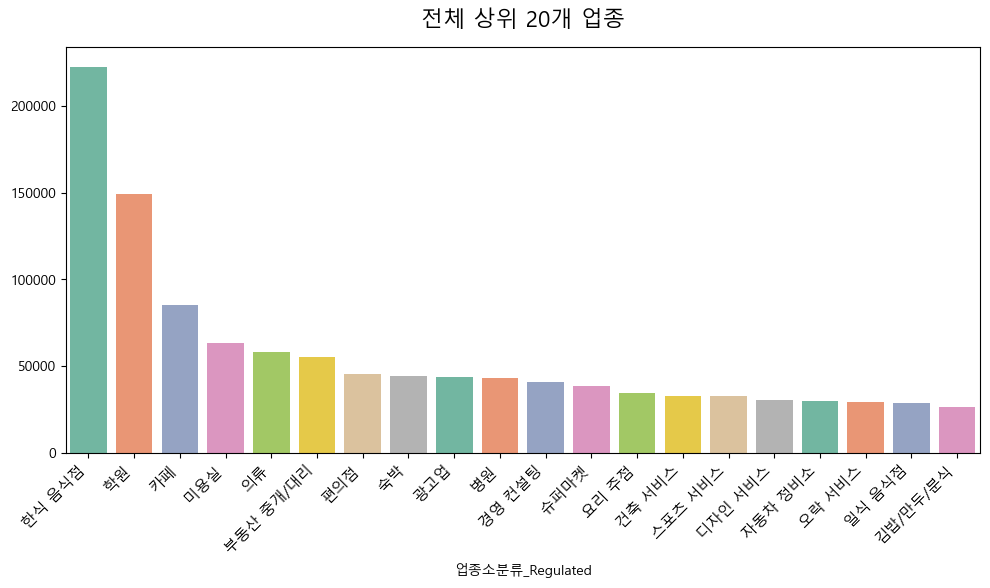

In [81]:
# 전체 상위 20개 업종
plt.figure(figsize=(10, 6))
categories_all = proc_shop_cat_df['업종소분류_Regulated'].value_counts().head(20)
sns.barplot(x=categories_all.index, y=categories_all.values, palette='Set2')
plt.title('전체 상위 20개 업종', fontsize=16, y=1.03)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.tight_layout()
plt.show()

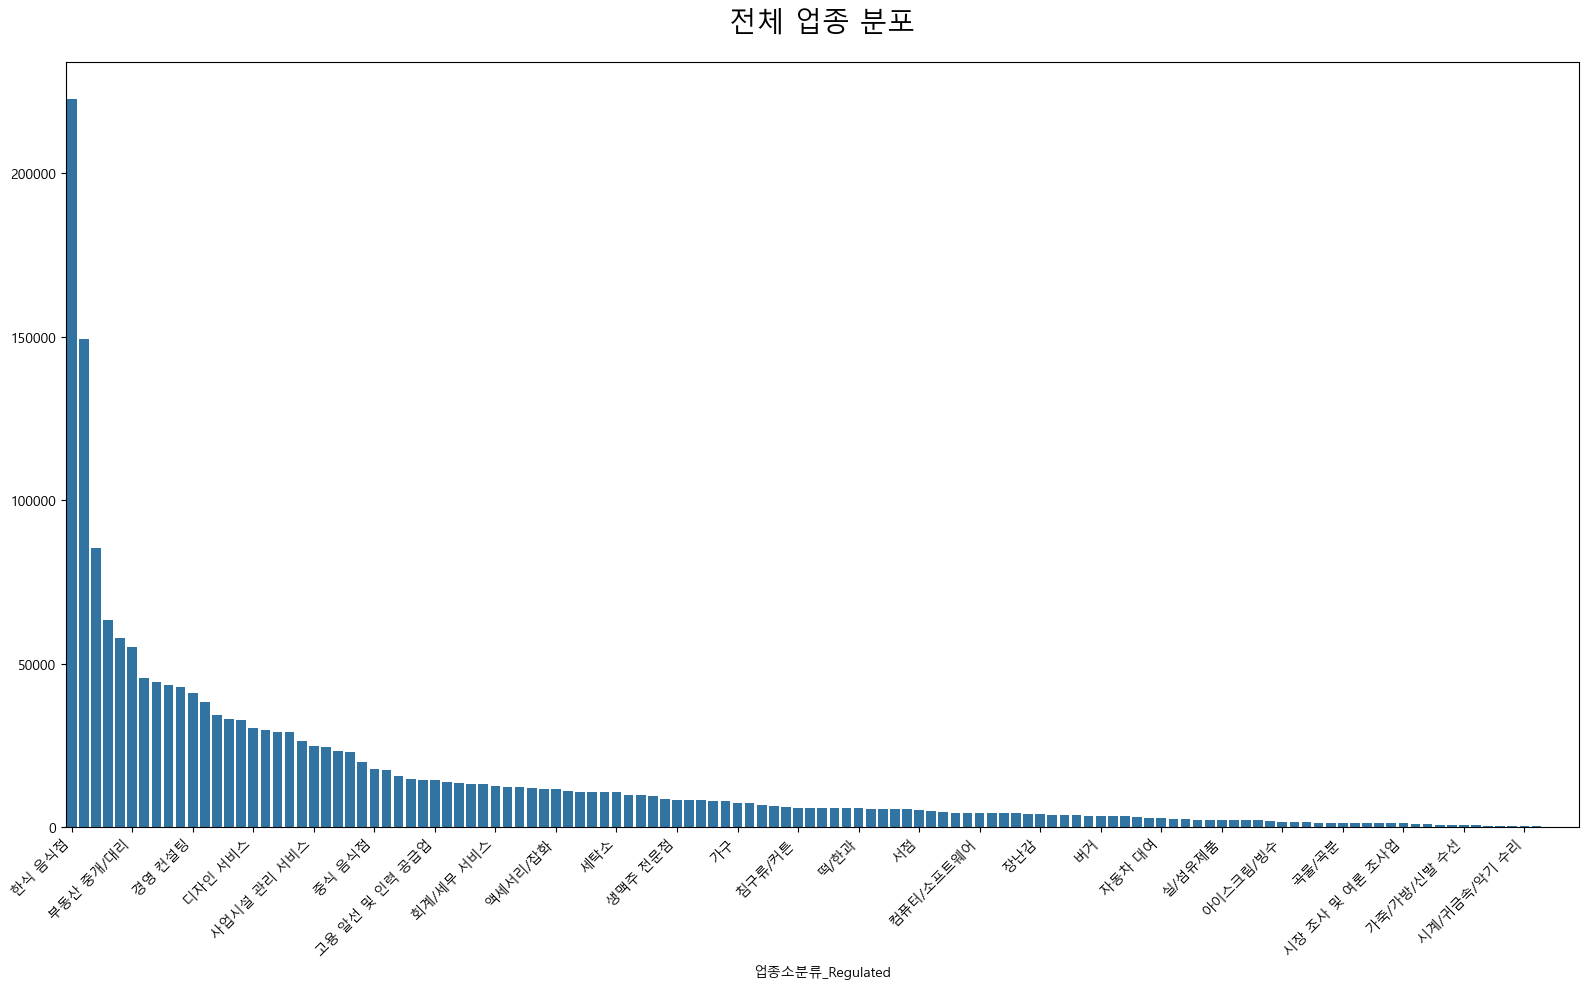

가장 많은 클래스: 한식 음식점 (222787개)
가장 적은 클래스: 음반/비디오물 대여 (74개)
3010.64배 차이


In [82]:
# 전체 업종
step = 5

plt.figure(figsize=(16, 10))
categories_all = proc_shop_cat_df['업종소분류_Regulated'].value_counts()
ax = sns.barplot(x=categories_all.index, y=categories_all.values)
plt.title('전체 업종 분포', fontsize=20, y=1.03)
xticks = [i for i in range(0, len(categories_all.index), step)]
xticklabels = [categories_all.index[i] for i in xticks]
plt.xticks(xticks, labels=xticklabels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 가장 많은 클래스 (최대값)
max_idx = categories_all.values.argmax()
max_class = categories_all.index[max_idx]
max_count = categories_all.values[max_idx]
print(f"가장 많은 클래스: {max_class} ({max_count}개)")

# 가장 적은 클래스 (최소값)
min_idx = categories_all.values.argmin()
min_class = categories_all.index[min_idx]
min_count = categories_all.values[min_idx]
print(f"가장 적은 클래스: {min_class} ({min_count}개)")
print(f"{max_count/min_count:.2f}배 차이")

In [83]:
# 최종 데이터셋
final_df = proc_shop_cat_df[['상가업소번호', '지역', '상호명_Regulated', '업종소분류_Regulated', '클래스']]

In [84]:
# 데이터 저장 디렉토리 생성
output_dir = './processed_data'
os.makedirs(output_dir, exist_ok=True)

# CSV 파일로 저장
output_path = f"{output_dir}/region_all_processed_data_remap.csv"
final_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"\n통합 데이터가 저장되었습니다: {output_path}")
print(f"최종 데이터 크기: {final_df.shape}")


통합 데이터가 저장되었습니다: ./processed_data/region_all_processed_data_remap.csv
최종 데이터 크기: (1818083, 5)


In [85]:
# 지역별 데이터도 따로 저장
for region in final_df['지역'].unique():
    region_df = final_df[final_df['지역'] == region]
    region_output = f"{output_dir}/regions/{region}_processed_data.csv"
    region_df.to_csv(region_output, index=False, encoding='utf-8')
    print(f"{region} 데이터 저장 완료: {region_output} (크기: {region_df.shape})")

강원 데이터 저장 완료: ./processed_data/regions/강원_processed_data.csv (크기: (93260, 5))
경기 데이터 저장 완료: ./processed_data/regions/경기_processed_data.csv (크기: (484073, 5))
경남 데이터 저장 완료: ./processed_data/regions/경남_processed_data.csv (크기: (117788, 5))
경북 데이터 저장 완료: ./processed_data/regions/경북_processed_data.csv (크기: (95510, 5))
광주 데이터 저장 완료: ./processed_data/regions/광주_processed_data.csv (크기: (49426, 5))
대구 데이터 저장 완료: ./processed_data/regions/대구_processed_data.csv (크기: (74362, 5))
대전 데이터 저장 완료: ./processed_data/regions/대전_processed_data.csv (크기: (48390, 5))
부산 데이터 저장 완료: ./processed_data/regions/부산_processed_data.csv (크기: (96308, 5))
서울 데이터 저장 완료: ./processed_data/regions/서울_processed_data.csv (크기: (354572, 5))
세종 데이터 저장 완료: ./processed_data/regions/세종_processed_data.csv (크기: (9441, 5))
울산 데이터 저장 완료: ./processed_data/regions/울산_processed_data.csv (크기: (31408, 5))
인천 데이터 저장 완료: ./processed_data/regions/인천_processed_data.csv (크기: (79504, 5))
전남 데이터 저장 완료: ./processed_data/regions/전남_processed_data.csv (

(-1.0999999968434606,
 1.0999999367199575,
 -1.3068072641183066,
 1.1098479541612998)

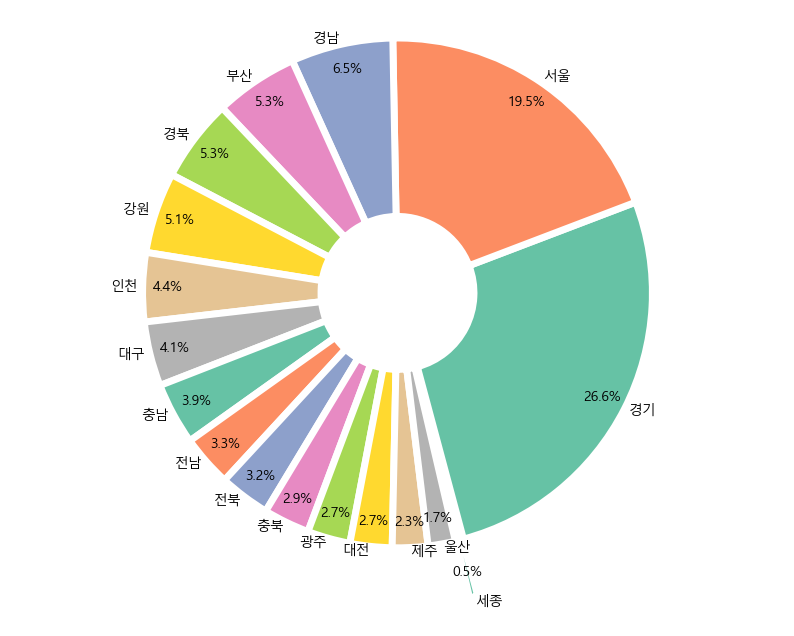

In [86]:
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.figure(figsize=(10, 8))
plt.pie(region_counts,
        labels=region_counts.index,
        autopct='%1.1f%%',
        startangle=-75,
        wedgeprops=wedgeprops,
        colors=sns.color_palette("Set2", len(region_counts)),
        labeldistance=1.02,
        pctdistance=0.9,
        explode=[0] * (len(region_counts)-1) + [0.23] # 각 조각을 약간 띄움
        )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [87]:
# 전체 데이터 요약
print("\n=== 데이터 통합 및 처리 요약 ===")
print(f"통합 데이터 크기: {region_all_df.shape}")
print(f"중복 처리 후 데이터 크기: {processed_df.shape}")
print(f"제거된 중복 레코드 수: {len(region_all_df) - len(processed_df)}")
print(f"데이터 감소율: {(len(region_all_df) - len(processed_df)) / len(region_all_df):.2%}")
print(f"고유 상호명 수: {final_df['상호명_Regulated'].nunique():,}개")
print(f"고유 업종 수: {final_df['업종소분류_Regulated'].nunique():,}개")

# 지역별 통계
print("\n지역별 통계:")
for region in final_df['지역'].unique():
    region_df = final_df[final_df['지역'] == region]
    print(f"- {region} 데이터: {len(region_df):,}개 ({len(region_df)/len(processed_df):.1%})")
    print(f"  고유 상호명 수: {region_df['상호명_Regulated'].nunique():,}개")
    print(f"  고유 업종 수: {region_df['업종소분류_Regulated'].nunique():,}개")
    print(f"  가장 많은 업종: {region_df['업종소분류_Regulated'].value_counts().index[0]}")


=== 데이터 통합 및 처리 요약 ===
통합 데이터 크기: (2792839, 6)
중복 처리 후 데이터 크기: (1818083, 6)
제거된 중복 레코드 수: 974756
데이터 감소율: 34.90%
고유 상호명 수: 1,818,083개
고유 업종 수: 125개

지역별 통계:
- 강원 데이터: 93,260개 (5.1%)
  고유 상호명 수: 93,260개
  고유 업종 수: 125개
  가장 많은 업종: 한식 음식점
- 경기 데이터: 484,073개 (26.6%)
  고유 상호명 수: 484,073개
  고유 업종 수: 125개
  가장 많은 업종: 한식 음식점
- 경남 데이터: 117,788개 (6.5%)
  고유 상호명 수: 117,788개
  고유 업종 수: 125개
  가장 많은 업종: 한식 음식점
- 경북 데이터: 95,510개 (5.3%)
  고유 상호명 수: 95,510개
  고유 업종 수: 125개
  가장 많은 업종: 한식 음식점
- 광주 데이터: 49,426개 (2.7%)
  고유 상호명 수: 49,426개
  고유 업종 수: 125개
  가장 많은 업종: 한식 음식점
- 대구 데이터: 74,362개 (4.1%)
  고유 상호명 수: 74,362개
  고유 업종 수: 125개
  가장 많은 업종: 한식 음식점
- 대전 데이터: 48,390개 (2.7%)
  고유 상호명 수: 48,390개
  고유 업종 수: 125개
  가장 많은 업종: 한식 음식점
- 부산 데이터: 96,308개 (5.3%)
  고유 상호명 수: 96,308개
  고유 업종 수: 125개
  가장 많은 업종: 한식 음식점
- 서울 데이터: 354,572개 (19.5%)
  고유 상호명 수: 354,572개
  고유 업종 수: 125개
  가장 많은 업종: 학원
- 세종 데이터: 9,441개 (0.5%)
  고유 상호명 수: 9,441개
  고유 업종 수: 119개
  가장 많은 업종: 학원
- 울산 데이터: 31,408개 (1.7%)
  고유 상호명 수: 31,408개

In [88]:
# 상호명 길이 분포
final_df['상호명_Regulated_길이'] = final_df['상호명_Regulated'].apply(len)

# 길이 통계
print("\n상호명 길이 통계:")
print(final_df[['상호명_Regulated_길이']].describe())


상호명 길이 통계:
       상호명_Regulated_길이
count      1.818083e+06
mean       6.677784e+00
std        2.952839e+00
min        0.000000e+00
25%        5.000000e+00
50%        6.000000e+00
75%        8.000000e+00
max        5.100000e+01


C:\Users\hojin\AppData\Local\Temp\ipykernel_34264\3310702641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['상호명_Regulated_길이'] = final_df['상호명_Regulated'].apply(len)


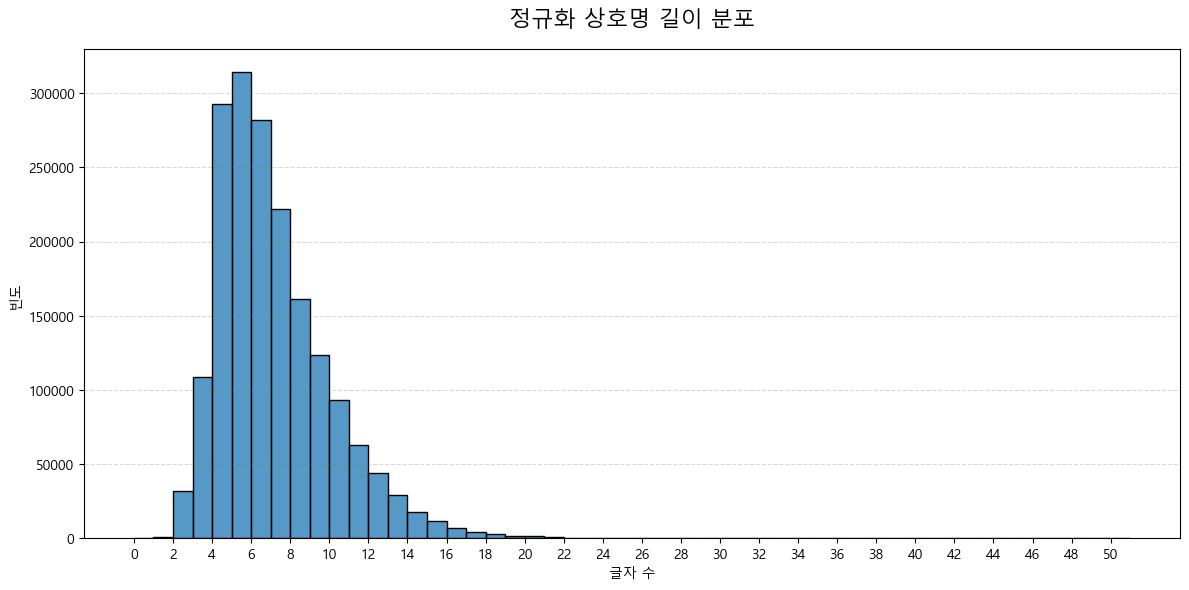

In [89]:
# 상호명 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(final_df['상호명_Regulated_길이'], bins=51)
plt.title('정규화 상호명 길이 분포', fontsize=16, y=1.03)
plt.xlabel('글자 수')
plt.ylabel('빈도')
min_x = int(final_df['상호명_Regulated_길이'].min())
max_x = int(final_df['상호명_Regulated_길이'].max())
plt.xticks(np.arange(min_x, max_x + 1, 2))
plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
plt.tight_layout()
plt.show()

C:\Users\hojin\AppData\Local\Temp\ipykernel_34264\491832076.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='업종소분류_Regulated', y='상호명_Regulated_길이', data=filtered_data, order=top_categories, palette='Set2')


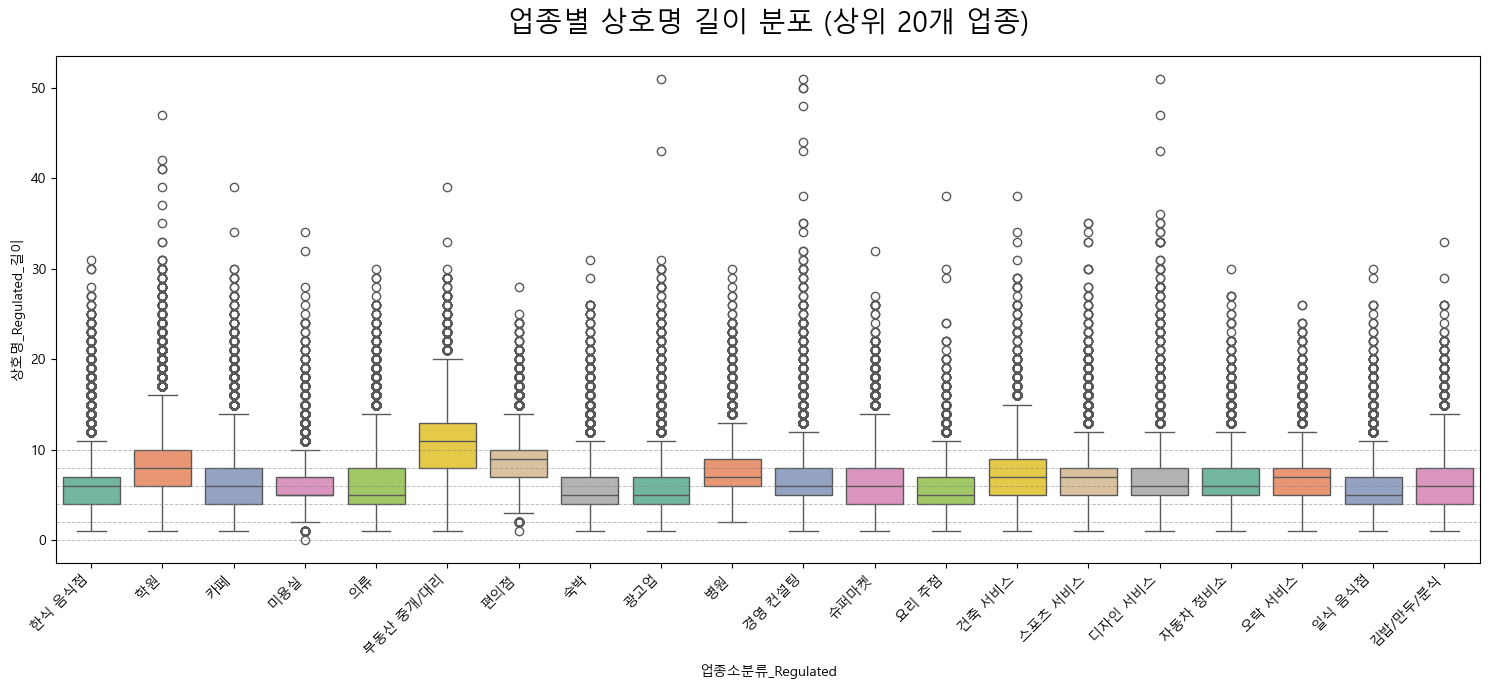

한식 음식점: 222,787개
학원: 149,275개
카페: 85,327개
미용실: 63,287개
의류: 57,995개
부동산 중개/대리: 55,126개
편의점: 45,768개
숙박: 44,253개
광고업: 43,565개
병원: 42,899개
경영 컨설팅: 41,109개
슈퍼마켓: 38,288개
요리 주점: 34,400개
건축 서비스: 33,023개
스포츠 서비스: 32,886개
디자인 서비스: 30,216개
자동차 정비소: 29,727개
오락 서비스: 29,219개
일식 음식점: 29,038개
김밥/만두/분식: 26,295개


In [90]:
# 업종별 상호명 길이 분석
counts = 20
category_counts = final_df['업종소분류_Regulated'].value_counts()
top_categories = category_counts.head(counts).index.tolist()
plt.figure(figsize=(15, 7))  # 그래프 크기 조금 더 늘림

# 데이터 필터링
filtered_data = final_df[final_df['업종소분류_Regulated'].isin(top_categories)]

# boxplot 생성 
sns.boxplot(x='업종소분류_Regulated', y='상호명_Regulated_길이', data=filtered_data, order=top_categories, palette='Set2')
plt.title(f'업종별 상호명 길이 분포 (상위 {counts}개 업종)', fontsize=20, y=1.03)
plt.xticks(rotation=45, ha='right')
for y in range(0, 11, 2):
    plt.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.tight_layout()
plt.show()

# 업종별 데이터 개수 확인 (확인용)
for category in top_categories:
    count = len(filtered_data[filtered_data['업종소분류_Regulated'] == category])
    print(f"{category}: {count:,}개")